<a href="https://colab.research.google.com/github/nischal1234/DS7010final/blob/main/Text_DS7010_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Text**

In [12]:
import pandas as pd
import numpy as np
import pickle

import itertools
import xgboost as xgb
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

#################################
#x_train = pd.read_csv('/content/drive/MyDrive/DS7010/emorec_data/s2e/audio_train.csv')
#x_test = pd.read_csv('/content/drive/MyDrive/DS7010/emorec_data/s2e/audio_test.csv')
#################################
#df = pd.read_csv('/content/drive/MyDrive/DS7010/emorec_data/t2e/text_train.csv')
#df = df.append(pd.read_csv('/content/drive/MyDrive/DS7010/emorec_data/t2e/text_test.csv'))
#display(df.head())
# Read train and test CSV files
train_df = pd.read_csv('/content/drive/MyDrive/DS7010/emorec_data/t2e/text_train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/DS7010/emorec_data/t2e/text_test.csv')

# Concatenate train and test data
df = pd.concat([train_df, test_df], ignore_index=True)

# Display the first few rows of the combined DataFrame
print(df.head())

                 wav_file  label  \
0     Ses02F_impro04_F012      2   
1  Ses03F_script02_1_M030      4   
2  Ses02F_script03_2_M015      2   
3  Ses02F_script02_2_M025      2   
4  Ses04M_script03_1_M021      1   

                                       transcription  
0                or they ll never talk to me again .  
1                                         for real ?  
2                                          nothing .  
3                      you wanna get married again ?  
4  let s savor the delight of the moment . come a...  


In [14]:
df.head()

,wav_file,label,transcription
0,Ses02F_impro04_F012,2,or they ll never talk to me again .
1,Ses03F_script02_1_M030,4,for real ?
2,Ses02F_script03_2_M015,2,nothing .
3,Ses02F_script02_2_M025,2,you wanna get married again ?
4,Ses04M_script03_1_M021,1,let s savor the delight of the moment . come a...


In [15]:
df.columns

Index(['wav_file', 'label', 'transcription'], dtype='object')

In [16]:
df.columns = ['wav_file','label', 'transcription']

In [17]:
category_to_id = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}
id_to_category = {0: 'ang', 1: 'hap', 2: 'sad', 3: 'fea', 4: 'sur', 5: 'neu'}

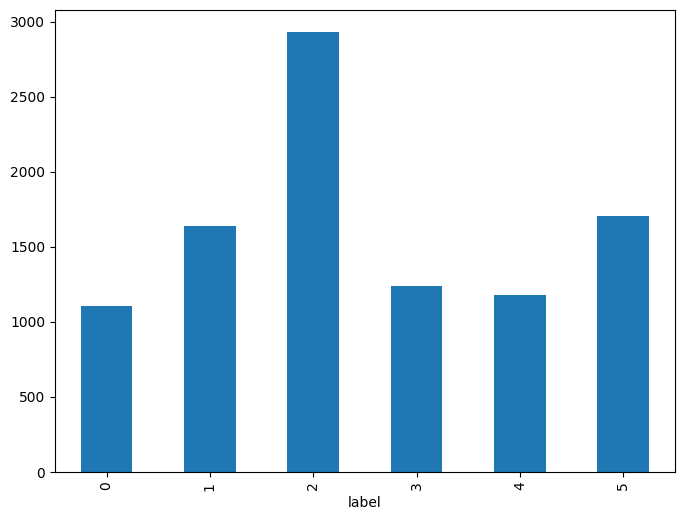

In [18]:
fig = plt.figure(figsize=(8,6))
df.groupby('label').transcription.count().plot.bar(ylim=0)
plt.show()

In [19]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.transcription).toarray()

labels = df.label
print(features.shape)

(9797, 2464)


In [20]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.20)
# count_vect = CountVectorizer()
# x_train_counts = count_vect.fit_transform(x_train)
# tfidf_transformer = TfidfTransformer()
# x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

In [21]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}

emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

# **RF**

Test Set Accuracy =  0.617
Test Set F-score =  0.608
Test Set Precision =  0.634
Test Set Recall =  0.619
Confusion matrix, without normalization
[[ 88  12  84  20   7  11]
 [  4 168  73  17  10  40]
 [ 32  47 396  56  11  54]
 [  0   0   0 258   0   0]
 [  0   0   0  56 181   0]
 [ 10  25 126  34  22 118]]


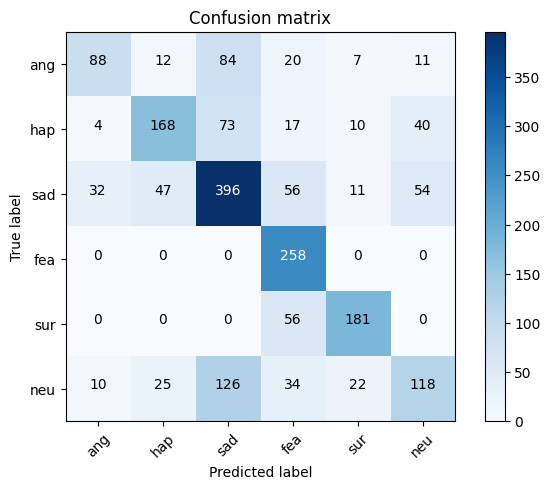

In [22]:
rf_classifier = RandomForestClassifier(n_estimators=600, min_samples_split=25)
rf_classifier.fit(x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('/content/drive/MyDrive/DS7010/saved_pickle/text_rf_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

# **Logistic**

Test Set Accuracy =  0.615
Test Set F-score =  0.624
Test Set Precision =  0.682
Test Set Recall =  0.596
Confusion matrix, without normalization
[[ 94  12  90   4   6  16]
 [  3 186  75   7   6  35]
 [ 26  41 451   8   4  66]
 [  0   0  58 200   0   0]
 [  4   4  63   3 163   0]
 [  9  32 165   7  10 112]]


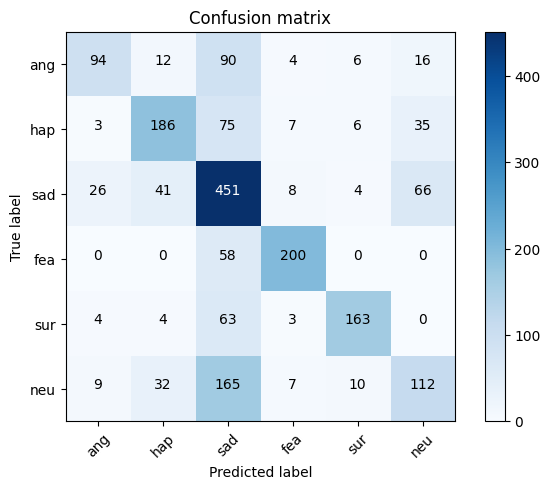

In [24]:
lr_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)

lr_classifier.fit(x_train, y_train)

# Predict
pred_probs = lr_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('/content/drive/MyDrive/DS7010/saved_pickle/text_lr_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

# **Extreme Gradient Boosting**

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:50:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Test Set Accuracy =  0.547
Test Set F-score =  0.534
Test Set Precision =  0.675
Test Set Recall =  0.496
Confusion matrix, without normalization
[[ 50  13 143   3   4   9]
 [  3 114 159   6   3  27]
 [ 16  38 501   1   2  38]
 [  0   0  62 196   0   0]
 [  4   2 105   0 126   0]
 [  4  23 216   4   3  85]]


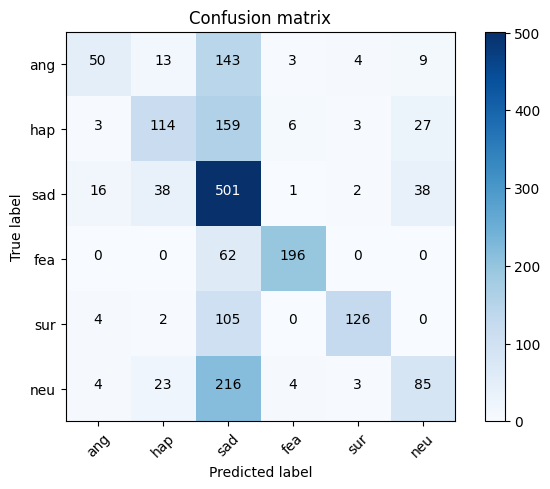

In [23]:
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob',
                                   n_estimators=600, sub_sample=0.8, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('/content/drive/MyDrive/DS7010/saved_pickle/text_xgb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

# **MLP**

Test Set Accuracy =  0.628
Test Set F-score =  0.629
Test Set Precision =  0.642
Test Set Recall =  0.638
Confusion matrix, without normalization
[[112   6  56  20   6  22]
 [  6 175  45  14   7  65]
 [ 42  36 374  50   7  87]
 [  0   0   0 258   0   0]
 [  4   0   0  56 167  10]
 [ 22  36  95  30   7 145]]


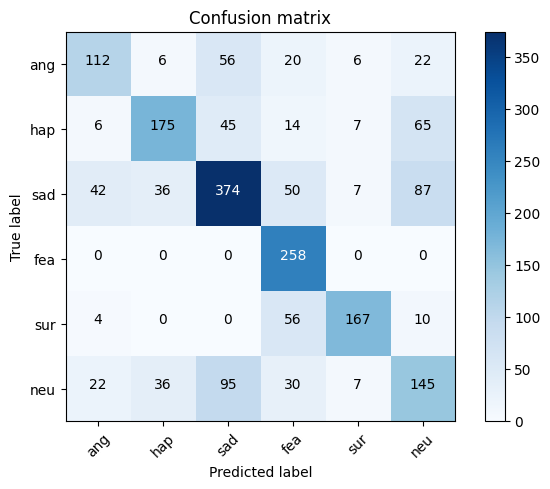

In [25]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.01,
                               power_t=0.5, max_iter=1000, shuffle=True, random_state=None, tol=0.0001,
                               verbose=False, warm_start=True, momentum=0.8, nesterovs_momentum=True,
                               early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
                               epsilon=1e-08)

mlp_classifier.fit(x_train, y_train)

# Predict
pred_probs = mlp_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('/content/drive/MyDrive/DS7010/saved_pickle/text_mlp_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

# **ensemble learning**

Test Set Accuracy =  0.619
Test Set F-score =  0.631
Test Set Precision =  0.682
Test Set Recall =  0.602
Confusion matrix, without normalization
[[ 99   6  93   3   5  16]
 [  4 178  64   6   5  55]
 [ 35  36 447   7   4  67]
 [  0   0  58 200   0   0]
 [  4   2  63   3 165   0]
 [ 16  31 150   5   8 125]]


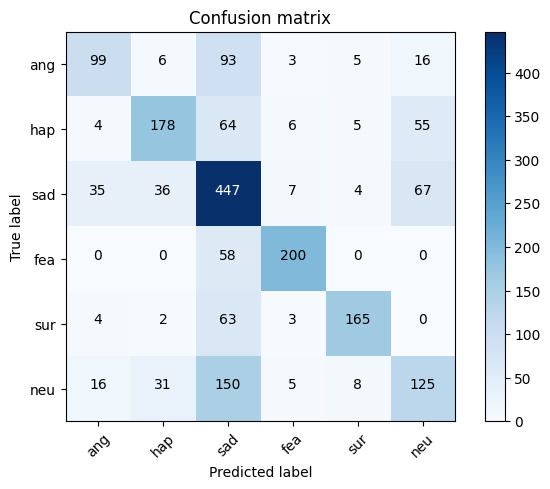

In [26]:
# Load predicted probabilities
with open('/content/drive/MyDrive/DS7010/saved_pickle/text_rf_classifier.pkl', 'rb') as f:
    rf_pred_probs = pickle.load(f)

with open('/content/drive/MyDrive/DS7010/saved_pickle/text_xgb_classifier.pkl', 'rb') as f:
    xgb_pred_probs = pickle.load(f)

with open('/content/drive/MyDrive/DS7010/saved_pickle/text_mlp_classifier.pkl', 'rb') as f:
    mlp_pred_probs = pickle.load(f)

with open('/content/drive/MyDrive/DS7010/saved_pickle/text_lr_classifier.pkl', 'rb') as f:
    lr_pred_probs = pickle.load(f)


# Average of the predicted probabilites
ensemble_pred_probs = (xgb_pred_probs +
                       mlp_pred_probs +
                       rf_pred_probs +
                       lr_pred_probs)/4.0


# Show metrics
display_results(y_test, ensemble_pred_probs)